In [1]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['axes.formatter.useoffset'] = False
import matplotlib.pyplot as plt
import nest
import numpy as np
import os
import re

from pynestml.codegeneration.nest_code_generator_utils import NESTCodeGeneratorUtils
module_name, neuron_model_name = NESTCodeGeneratorUtils.generate_code_for(
    nestml_neuron_model="rb_neuron.nestml",
    module_name="rb_neuron_module")


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.7.0
 Built: May 24 2024 10:11:53

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.7.0
 Built: May 24 2024 10:11:53

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

[22,rb_neuron_nestml, WARNING, [62:8;62:20]]: Variable 'k' has the same name as a physical unit!
[23,rb_neuron_nestml, WARNING, [23:17;23:28]]: Model contains a call to fixed-timestep functions (``resolution()`` and/or ``steps()``). This restricts the model to being compatible only with fixed-timestep simulators. Consider eliminating ``re


Jul 01 19:42:58 Install [Info]: 
    loaded module rb_neuron_module

Jul 01 19:42:58 NodeManager::prepare_nodes [Info]: 
    Preparing 503 nodes for simulation.

Jul 01 19:42:58 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 503
    Simulation time (ms): 500
    Number of OpenMP threads: 1
    Not using MPI

Jul 01 19:42:58 SimulationManager::run [Info]: 
    Simulation finished.


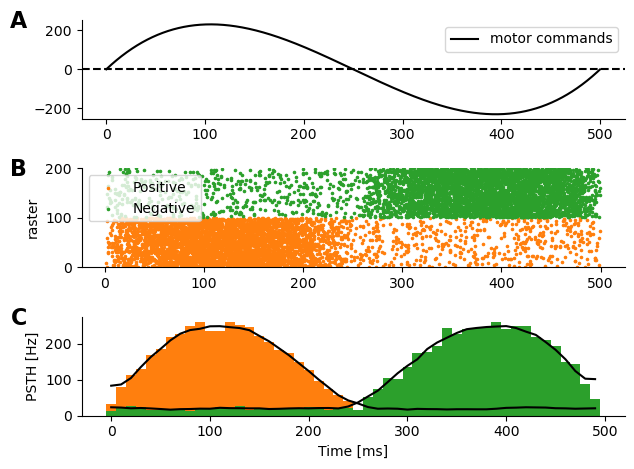

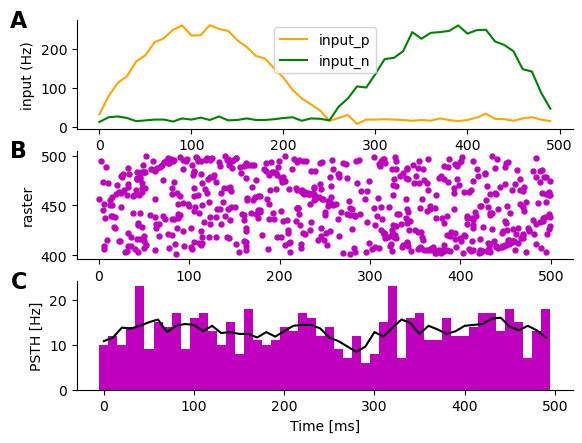

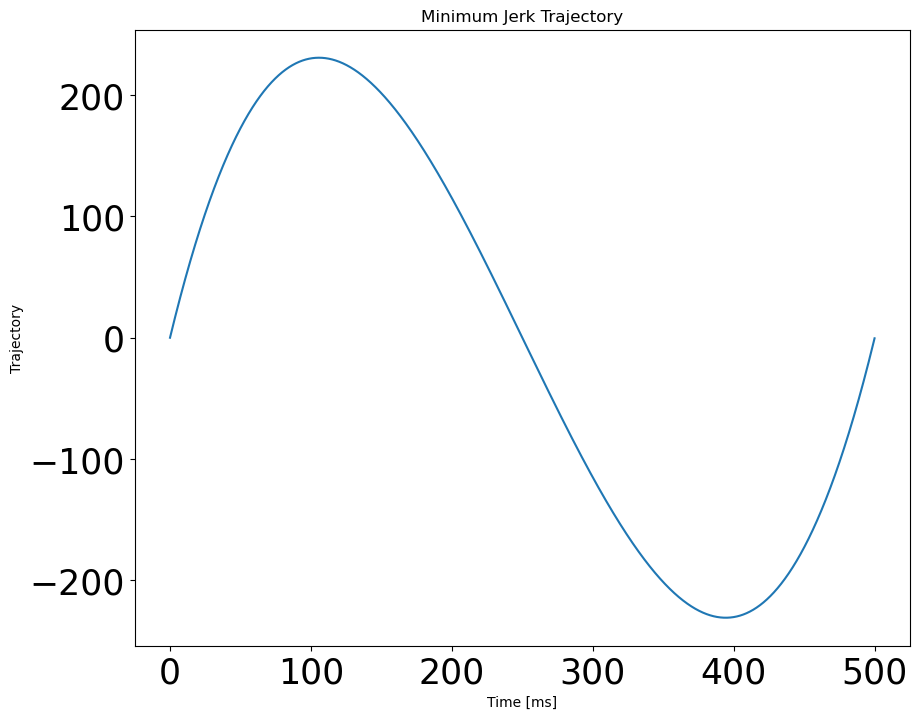

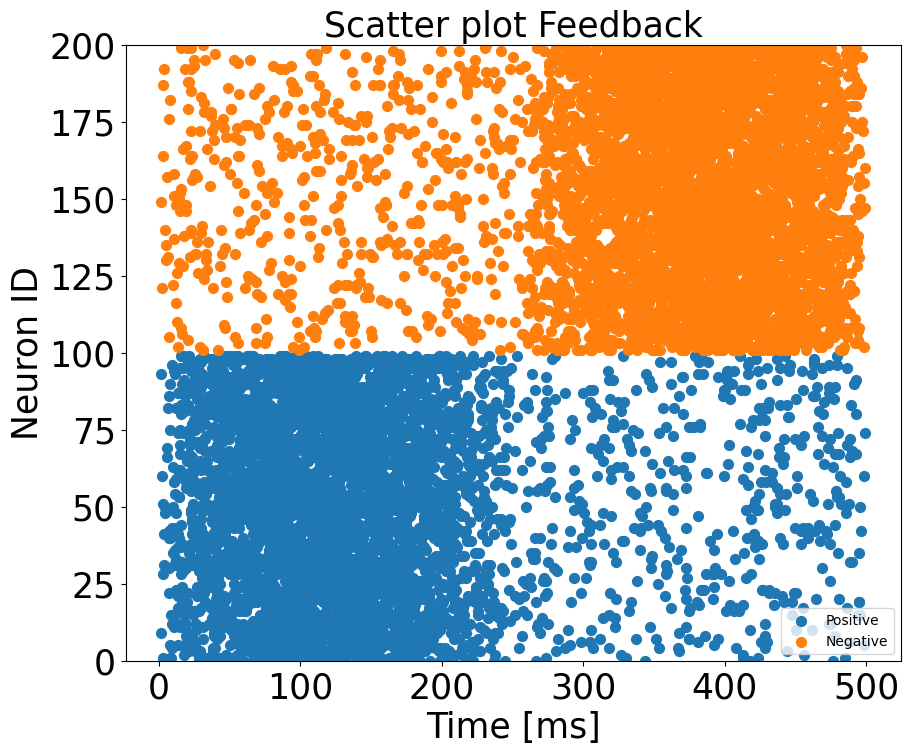

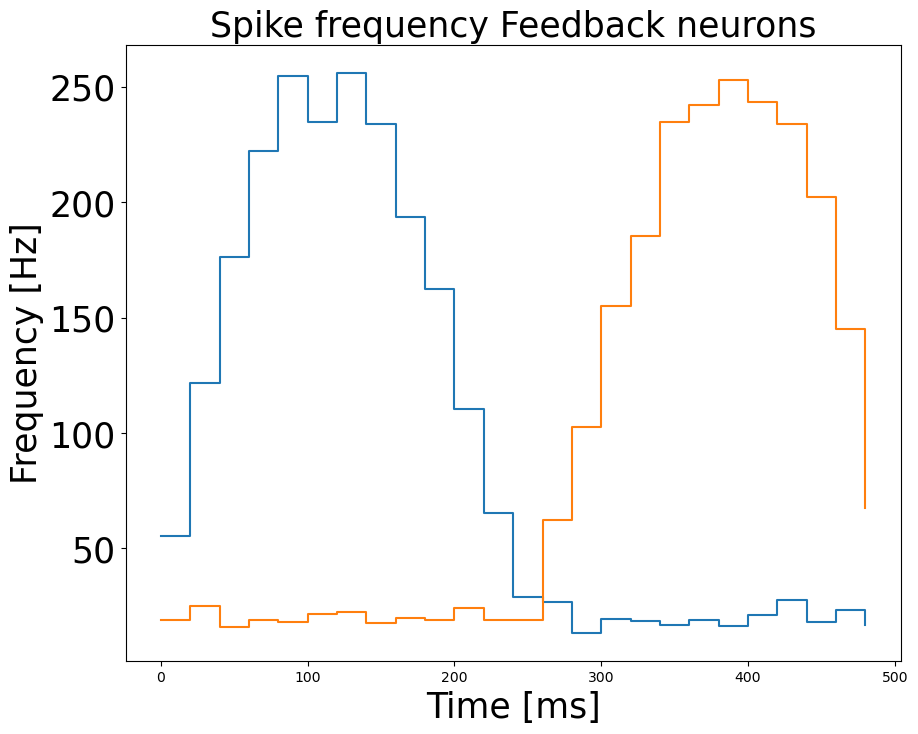

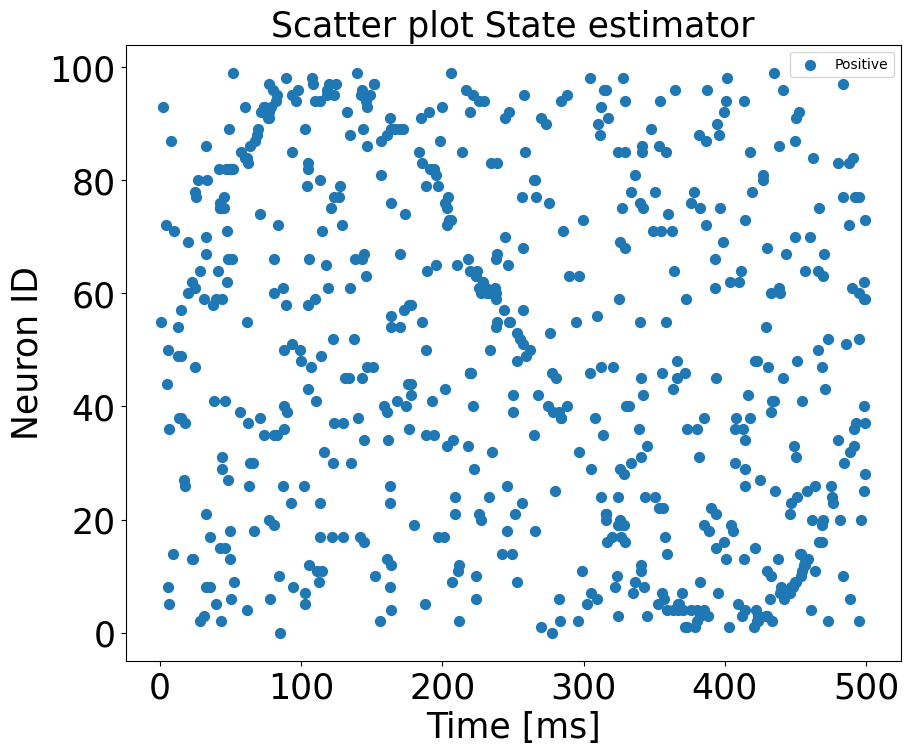

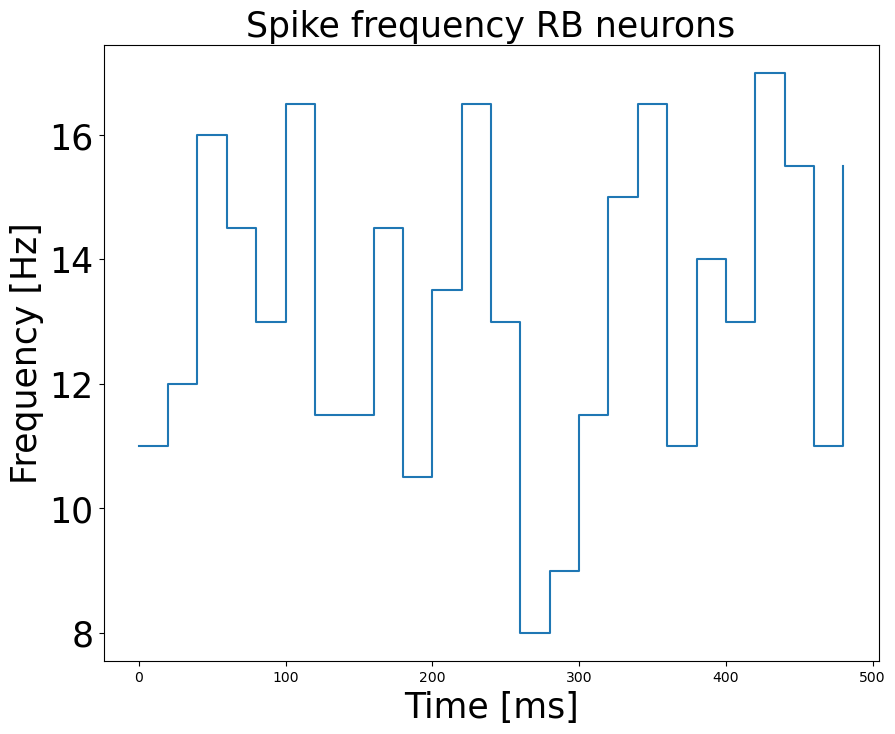

In [2]:
nest.ResetKernel()
nest.Install("rb_neuron_module")
res = nest.GetKernelStatus('resolution')
def desiredTrajectory(x_init, x_des, T_max, timespan):
    a =   6*(x_des-x_init)/np.power(T_max,5)
    b = -15*(x_des-x_init)/np.power(T_max,4)
    c =  10*(x_des-x_init)/np.power(T_max,3)
    d =  0
    e =  0
    g =  x_init

    pp = a*np.power(timespan,5) + b*np.power(timespan,4) + c*np.power(timespan,3) + g
    #pol = np.array([a,b,c,d,e,g])
    return pp

def minimumJerk_ddt(x_init, x_des, T_max, timespan):
    a =  120*(x_des-x_init)/np.power(T_max,5)
    b = -180*(x_des-x_init)/np.power(T_max,4)
    c =  60*(x_des-x_init)/np.power(T_max,3)
    if hasattr(x_init, "shape"):
        d =  np.zeros(x_init.shape)
    else:
        d =  np.zeros(1)

    #pol = np.array([a,b,c,d])
    pp  = a*np.power(timespan,3) + b*np.power(timespan,2) + c*np.power(timespan,1) + d

    return pp
### Parameters
time_span = 500.0
time_vect = np.arange(0, time_span, res)
buf_size  = 10.0
trial_len = 500
n_trial   = 1

Ns = 100

base_rate_rb = 10.0
base_rate_feedback = 20.0

gain_feedback = 1.0
gain_rb = 3.0
### Create trajectories and convert them to spike trains
# trj_real  = desiredTrajectory(0.0, 100.0, time_span, time_vect)
trj_real  = minimumJerk_ddt(0.0, 1e7,time_span, time_vect)
#### Sensory feedback
trj_real_p = np.zeros(len(trj_real))
trj_real_p[trj_real>=0] = trj_real[trj_real>=0]
feedback_p = nest.Create("inhomogeneous_poisson_generator",Ns)
for i, neuron in enumerate(feedback_p):
    nest.SetStatus(neuron, {"rate_times": time_vect[1:], "rate_values": base_rate_feedback+gain_feedback*np.abs(trj_real_p[1:])})
feedback_p_prt = nest.Create("parrot_neuron",Ns)
nest.Connect(feedback_p,feedback_p_prt, "one_to_one")

trj_real_n = np.zeros(len(trj_real))
trj_real_n[trj_real<0] = trj_real[trj_real<0]
feedback_n = nest.Create("inhomogeneous_poisson_generator",Ns)
for i, neuron in enumerate(feedback_n):
    nest.SetStatus(neuron, {"rate_times": time_vect[1:], "rate_values": base_rate_feedback+gain_feedback*np.abs(trj_real_n[1:])})
feedback_n_prt = nest.Create("parrot_neuron",Ns)
nest.Connect(feedback_n,feedback_n_prt, "one_to_one")
#### Radial basis neuron
stEst_p = nest.Create("rb_neuron_nestml", Ns)
nest.SetStatus(stEst_p, {"kp": gain_rb, "buffer_size":buf_size, "base_rate": base_rate_rb, "simulation_steps": int(trial_len/res)})
freq_max = 70
signal_sensibility = np.linspace(-freq_max,freq_max,len(stEst_p))
for i,neuron in enumerate(stEst_p):
    nest.SetStatus(neuron, {"desired": signal_sensibility[i]})

syn_exc = {"weight": 1.0}
syn_inh = {"weight": -1.0}

# Connections to RB neurons
nest.Connect(feedback_p_prt, stEst_p, "all_to_all", syn_spec=syn_exc)
nest.Connect(feedback_n_prt, stEst_p, "all_to_all", syn_spec=syn_inh)
nest.node_models
### Devices
spikedet_feedback_p = nest.Create("spike_recorder")
nest.Connect(feedback_p_prt, spikedet_feedback_p)
spikedet_feedback_n = nest.Create("spike_recorder")
nest.Connect(feedback_n_prt, spikedet_feedback_n)

spikedet_stEst_p = nest.Create("spike_recorder")
nest.Connect(stEst_p, spikedet_stEst_p)
### Simulate
for trial in range(n_trial):
    nest.Simulate(trial_len)
### Recover data from devices
SD_feedback_p    = nest.GetStatus(spikedet_feedback_p,keys="events")[0]
SD_feedback_p_ev = SD_feedback_p["senders"]
SD_feedback_p_tm = SD_feedback_p["times"]

SD_feedback_n    = nest.GetStatus(spikedet_feedback_n,keys="events")[0]
SD_feedback_n_ev = SD_feedback_n["senders"]
SD_feedback_n_tm = SD_feedback_n["times"]

SD_stEst_p    = nest.GetStatus(spikedet_stEst_p,keys="events")[0]
SD_stEst_p_ev = SD_stEst_p["senders"]
SD_stEst_p_tm = SD_stEst_p["times"]
buf = 10
count_n_in, bins = np.histogram( SD_feedback_n_tm, bins=np.arange(0, time_span+1, buf) )
count_p_in, bins = np.histogram( SD_feedback_p_tm, bins=np.arange(0, time_span+1, buf) )
rate_n_in = 1000*count_n_in/(Ns*buf)
rate_p_in = 1000*count_p_in/(Ns*buf)

rate_padded = np.pad(rate_p_in, pad_width=2, mode='reflect') 
rate_sm_p = np.convolve(rate_padded, np.ones(5) / 5, mode='valid')
rate_padded = np.pad(rate_n_in, pad_width=2, mode='reflect') 
rate_sm_n = np.convolve(rate_padded, np.ones(5) / 5, mode='valid')

count, bins = np.histogram( SD_stEst_p_tm, bins=np.arange(0, time_span+1, buf) )
rate = 1000*count/(Ns*buf)
rate_padded = np.pad(rate, pad_width=2, mode='reflect') 
rate_sm = np.convolve(rate_padded, np.ones(5) / 5, mode='valid')

### Plotting 
# Input (mc out)
y_min = nest.GetStatus(feedback_p_prt)[0]['global_id']
y_max = nest.GetStatus(feedback_p_prt)[-1]['global_id']
fig, axes = plt.subplots(3,1)
axes[0].plot(time_vect, trj_real, 'k', label='motor commands')
axes[0].axhline(y=0, color='k', linestyle='--')
axes[0].legend()
axes[1].scatter(SD_feedback_p_tm , SD_feedback_p_ev-y_min, s=10, marker='.', c= "tab:orange", label = 'Positive')
axes[1].scatter(SD_feedback_n_tm , SD_feedback_n_ev-y_max, s=10, marker='.', c= "tab:green", label = 'Negative')
axes[1].set_ylim([0,nest.GetStatus(feedback_n_prt)[-1]['global_id']-y_max])
axes[1].set_ylabel('raster')
axes[1].legend()
axes[2].bar(bins[:-1], rate_p_in, width=bins[1]-bins[0], color= "tab:orange")
axes[2].bar(bins[:-1], rate_n_in, width=bins[1]-bins[0], color= "tab:green")
axes[2].plot(bins[:-1], rate_sm_p,'k')
axes[2].plot(bins[:-1], rate_sm_n,'k')
axes[2].set_xlabel('Time [ms]')
axes[2].set_ylabel('PSTH [Hz]')

subplot_labels = ['A', 'B', 'C']
for i, ax in enumerate(axes):
    ax.text(-0.1, 1.1, subplot_labels[i], transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top', ha='right')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
plt.tight_layout()
plt.savefig('rb_input.png')

from plotting import plotPopulation_sd
fig, axes = plt.subplots(3,1)
axes[0].plot(bins[:-1], rate_p_in, "orange", label="input_p")
axes[0].plot(bins[:-1], rate_n_in, "green", label="input_n")
axes[0].legend()
axes[0].set_ylabel("input (Hz)")             
axes[1].scatter(SD_stEst_p_tm, SD_stEst_p_ev, marker='.', s=50, color='m')
axes[1].set_ylabel("raster")
axes[2].bar(bins[:-1], rate, width=bins[1]-bins[0], color='m')
axes[2].plot(bins[:-1], rate_sm, color = 'k')
axes[2].set_ylabel('PSTH [Hz]')
axes[2].set_xlabel('Time [ms]')
for i, ax in enumerate(axes):
    ax.text(-0.1, 1.1, subplot_labels[i], transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top', ha='right')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
plt.savefig('rb.png')
np.savetxt('rate_rb.txt', rate)


# Feedback
#y_min = np.min(feedback_p_prt)
#y_max = np.max(feedback_p_prt)

plt.figure(figsize=(10,8))
plt.plot(time_vect,trj_real)
plt.xlabel('Time [ms]')
plt.ylabel('Trajectory')
plt.title('Minimum Jerk Trajectory')
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)

y_min = feedback_p_prt.get("global_id")[0]
y_max = feedback_p_prt.get("global_id")[-1]
plt.figure(figsize=(10,8))
plt.scatter(SD_feedback_p_tm , SD_feedback_p_ev-y_min, marker='.', s = 200, label = 'Positive')
plt.scatter(SD_feedback_n_tm , SD_feedback_n_ev-y_max, marker='.', s = 200, label = 'Negative')
plt.title('Scatter plot Feedback', size =25)
plt.xlabel('Time [ms]', size =25)
plt.ylabel('Neuron ID', size =25)
plt.ylim([0,feedback_n_prt.get("global_id")[-1]-y_max])
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.legend()

x_pos = []
x_neg = []
delta_t = 20
for i in range(0,trial_len*n_trial,delta_t):
    spikes_pos = [k for k in SD_feedback_p_tm if k<i+delta_t and k>=i]
    spikes_neg = [k for k in SD_feedback_n_tm if k<i+delta_t and k>=i]
    freq_pos = len(spikes_pos)/(delta_t/1000*Ns)
    freq_neg = len(spikes_neg)/(delta_t/1000*Ns)
    x_pos.append(freq_pos)
    x_neg.append(freq_neg)
feedback_signal = [i-j for (i,j) in zip(x_pos, x_neg)]
plt.figure(figsize=(10,8))
t = np.arange(0,trial_len*n_trial,delta_t)
t = np.repeat(t,2)[1:]
x_pos = np.repeat(x_pos,2)[:-1]
plt.plot(t,x_pos)
x_neg = np.repeat(x_neg,2)[:-1]
plt.plot(t,x_neg)
plt.title('Spike frequency Feedback neurons', size =25)
plt.xlabel('Time [ms]', size =25)
plt.ylabel('Frequency [Hz]', size =25)
plt.yticks(fontsize=25)

# RB neurons
#y_min = np.min(stEst_p)
y_min = stEst_p.get("global_id")[0]
plt.figure(figsize=(10,8))
plt.scatter(SD_stEst_p_tm , SD_stEst_p_ev-y_min, marker='.', s = 200, label = 'Positive')
plt.title('Scatter plot State estimator', size =25)
plt.xlabel('Time [ms]', size =25)
plt.ylabel('Neuron ID', size =25)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.legend()

x_pos = []
delta_t = 20
for i in range(0,trial_len*n_trial,delta_t):
    spikes_pos = [k for k in SD_stEst_p_tm if k<i+delta_t and k>=i]
    freq_pos = len(spikes_pos)/(delta_t/1000*Ns*n_trial)
    x_pos.append(freq_pos)
plt.figure(figsize=(10,8))
t = np.arange(0,trial_len*n_trial,delta_t)
t = np.repeat(t,2)[1:]
x_pos = np.repeat(x_pos,2)[:-1]
plt.plot(t,x_pos)
plt.title('Spike frequency RB neurons', size =25)
plt.xlabel('Time [ms]', size =25)
plt.ylabel('Frequency [Hz]', size =25)
plt.yticks(fontsize=25)

plt.show()